In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
screen_name = 'ola_supports'
db = MongoClient().get_database('not-truncated')
convs = list(db.conversations.find({'screen_name': screen_name, 'topics': {'$ne': []}}))
print('There are total', len(convs), 'conversations.')

There are total 603 conversations.


In [3]:
# flatten it

dataset = []
topics_to_ignore = ['undefined', 'poor_experience', 'random_query']
cant_coexist = [
    ('overcharged', 'payments'),
    ('cancellation_charged', 'overcharged'),
    ('driver_denied', 'cancellation_charged'),
]
# cant_coexist = []

multi_topic_convs = []

for c in convs:
    topics_here = [t for t in c['topics'] if t not in topics_to_ignore]
    
    # manually remove second topic from pairs if they co-exist
    for to_keep, to_discard in cant_coexist:
        if to_keep in topics_here and to_discard in topics_here:
            topics_here.remove(to_discard)
    
    
    for m in filter(lambda msg: msg['important'], c['messages']):
        multi_topic_convs.append({'message': m['processed_text'], 'topics': topics_here})
        for t in topics_here:
            dataset.append({'message': m['processed_text'].replace('\n', ''), 'topic': t})
        
multi_topic_df = pd.DataFrame(multi_topic_convs)
df = pd.DataFrame(dataset)
print(df.size, 'records')

df.head()

1730 records


,message,topic
0,"Hi Hetan, we are sorry for the denial. We have...",delay
1,"Hi Hetan, we are sorry for the denial. We have...",driver_denied
2,"What a morning ride Booked a mini cab, waited...",delay
3,"What a morning ride Booked a mini cab, waited...",driver_denied
4,I would like to know what action was taken reg...,ola_share


driver_denied           177
overcharged             140
misbehaviour            124
delay                    88
app_issue                87
customer_support         73
payments                 64
cancellation_charged     36
ola_share                22
ola_auto                 21
no_service               20
promo_codes               8
ola_outstation            5
Name: topic, dtype: int64
865


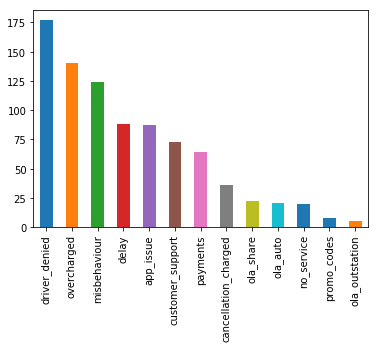

In [4]:
# get topic counts

topic_counts = df['topic'].value_counts()
print(topic_counts)
print(topic_counts.sum())
topic_counts.plot.bar()

60 is the cutoff frequency.
Selected topics are ['driver_denied' 'overcharged' 'misbehaviour' 'delay' 'app_issue'
 'customer_support' 'payments']
1730 records reduced to 1506 records.


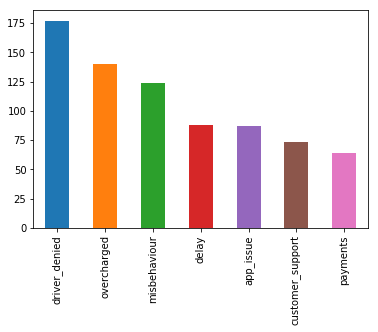

In [5]:
# remove insignificant topics
cutoff_freq = int(0.1 * len(convs))  # 10 % is manually selected, coz it's near 50
print(cutoff_freq, 'is the cutoff frequency.')

selected_topics = topic_counts[topic_counts > cutoff_freq]
print('Selected topics are', selected_topics.index.values)

l1 = df.size
df = df.loc[df['topic'].isin(selected_topics.index.values)]
l2 = df.size
print(l1, 'records reduced to', l2, 'records.')

original_df = df.copy()
df['topic'].value_counts().plot.bar()

In [6]:
# put topic_id on topics to make it a numerical value
df['topic_id'] = df['topic'].factorize()[0]

topic_id_df = df[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id', 'topic']].values)

In [7]:
# get features and labels using text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8',
                       ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.message)
labels = df['topic_id']
features.shape, labels.shape

((753, 620), (753,))

In [8]:
# find most correlated topics
from sklearn.feature_selection import chi2

N = 3
for topic, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split()) == 1]
    bigrams = [v for v in feature_names if len(v.split()) == 2]
    trigrams = [v for v in feature_names if len(v.split()) == 3]
    print('For', topic)
    print('\t', 'Unigrams >', unigrams[-N:])
    print('\t', 'Bigrams >', bigrams[-N:])

For app_issue
	 Unigrams > ['technical', 'login', 'app']
	 Bigrams > ['rs 50', 'app doesn', 'ola app']
For customer_support
	 Unigrams > ['days', 'care', 'customer']
	 Bigrams > ['15 days', 'customer care', 'customer service']
For delay
	 Unigrams > ['hour', 'waiting', 'mins']
	 Bigrams > ['half hour', 'mins cab', '30 mins']
For driver_denied
	 Unigrams > ['cancel', 'cancelling', 'cancelled']
	 Bigrams > ['denied duty', 'cancelled ride', 'driver cancelled']
For misbehaviour
	 Unigrams > ['rude', 'forced', 'driving']
	 Bigrams > ['ola driver', 'driver told', 'pls help']
For overcharged
	 Unigrams > ['shown', 'rs', 'fare']
	 Bigrams > ['longer route', 'extra cash', 'charged rs']
For payments
	 Unigrams > ['money', 'credit', 'payment']
	 Bigrams > ['pay cash', 'ola credit', 'ola money']


In [9]:
# make required imports for training on above dataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# for metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# for undersampling or oversampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours as ENN

# for some vis
import seaborn as sns

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['topic_id'], random_state=0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8',
                       ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)

print(X_train_tfidf.shape, Y_train.shape, X_test.shape, Y_test.shape)

(564, 443) (564,) (189,) (189,)


In [11]:
# some custom accuracy methods

def accuracy(clf):
    Y_pred = clf.predict(tfidf.transform(multi_topic_df['message']))
    total = sum(1 for a, p in zip(multi_topic_df['topics'], Y_pred) if id_to_topic[p] in a)
    return total / len(multi_topic_df)

In [12]:
# try models one by one

def run_a_model(model, imb=None):
    print('Running for', model.__class__.__name__, 'with imbalance fixing by', imb.__name__ if imb else None)
    if not imb:
        clf = model.fit(X_train_tfidf, Y_train)
    else:
        X_train_res, Y_train_res = imb(random_state=0).fit_sample(X_train_tfidf, Y_train)
        clf = model.fit(X_train_res, Y_train_res)
    Y_pred = clf.predict(tfidf.transform(X_test))

    print('Actual accuracy :', accuracy(clf))
    print('Model Accuracy :', accuracy_score(Y_test, Y_pred))
    print('Recall :', recall_score(Y_test, Y_pred, average='micro'))
    print('Precision :', precision_score(Y_test, Y_pred, average='micro'))

    conf_mat = confusion_matrix(Y_test, Y_pred)
    n_topics = len(selected_topics)
    fig, ax = plt.subplots(figsize=(n_topics, n_topics))
    sns.heatmap(conf_mat, annot=True, fmt='d', 
                xticklabels=selected_topics.index.values,
                yticklabels=selected_topics.index.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return clf

Running for MultinomialNB with imbalance fixing by SMOTE
Actual accuracy : 0.694006309148265
Model Accuracy : 0.3439153439153439
Recall : 0.3439153439153439
Precision : 0.3439153439153439


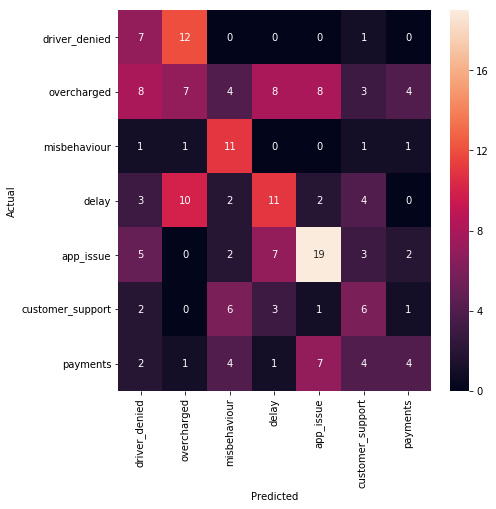

Running for LogisticRegression with imbalance fixing by SMOTE
Actual accuracy : 0.7160883280757098
Model Accuracy : 0.36507936507936506
Recall : 0.36507936507936506
Precision : 0.36507936507936506


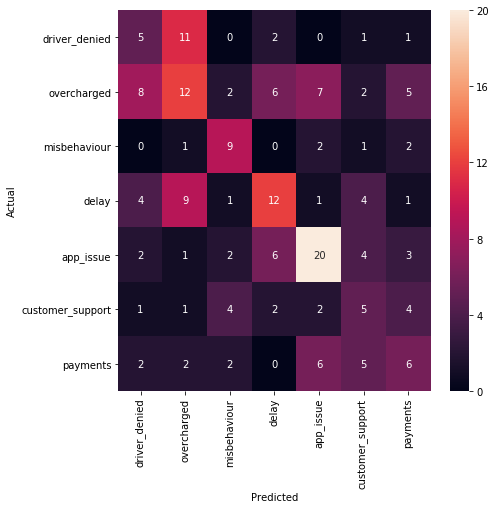

Running for LinearSVC with imbalance fixing by None
Actual accuracy : 0.7602523659305994
Model Accuracy : 0.2857142857142857
Recall : 0.2857142857142857
Precision : 0.2857142857142857


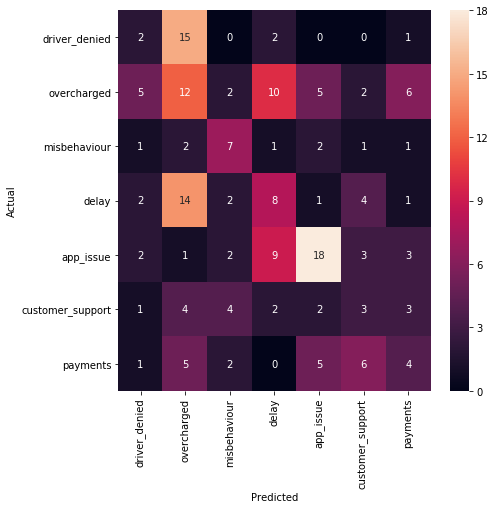

Running for LinearSVC with imbalance fixing by SMOTE
Actual accuracy : 0.7586750788643533
Model Accuracy : 0.2751322751322751
Recall : 0.2751322751322751
Precision : 0.2751322751322751


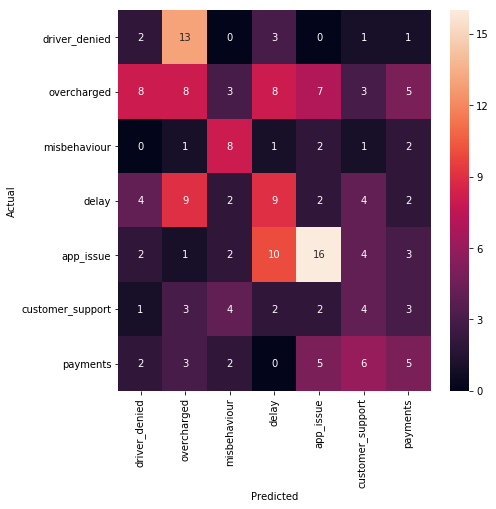

Running for RandomForestClassifier with imbalance fixing by SMOTE
Actual accuracy : 0.5788643533123028
Model Accuracy : 0.4126984126984127
Recall : 0.4126984126984127
Precision : 0.4126984126984127


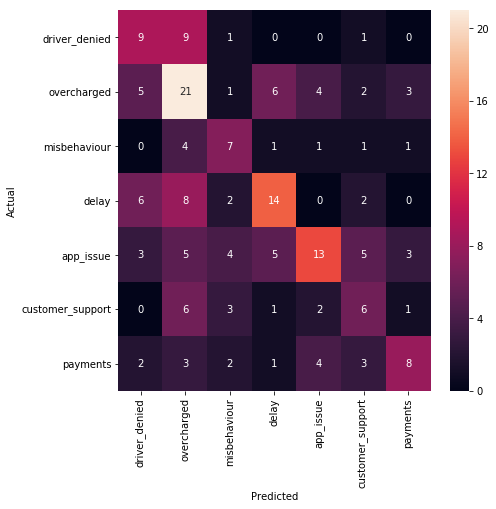

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [13]:
# multinomial naive bayes
# run_a_model(MultinomialNB())
run_a_model(MultinomialNB(), SMOTE)
# run_a_model(MultinomialNB(), ENN)

# logistic regression
# run_a_model(LogisticRegression(random_state=0))
run_a_model(LogisticRegression(random_state=0), SMOTE)
# run_a_model(LogisticRegression(random_state=0), ENN)

# linear svc
run_a_model(LinearSVC())
run_a_model(LinearSVC(), SMOTE)
# run_a_model(LinearSVC(), ENN)

# random forest classifier
# run_a_model(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0))
run_a_model(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), SMOTE)
# run_a_model(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), ENN)